In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
cd 'drive/MyDrive/Uni/UniPD/HumanDataProject/Code'

/content/drive/MyDrive/Uni/UniPD/HumanDataProject/Code


In [3]:
import threading
import random
import time
import subprocess
import sys
import seaborn as sns
import pandas as pd
import os
import numpy as np
from config import PREPROCESSING_PATH ,DATASET_SPLIT_PATH
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import models
from scipy.io import wavfile
import matplotlib.pyplot as plt



from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix,accuracy_score

In [4]:
!pip install tensorflow-io

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.4/49.4 MB 21.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.1/5.1 MB 99.6 MB/s eta 0:00:00
  Attempting uninstall: tensorflow-io-gcs-filesystem
    Found existing installation: tensorflow-io-gcs-filesystem 0.35.0
    Uninstalling tensorflow-io-gcs-filesystem-0.35.0:
      Successfully uninstalled tensorflow-io-gcs-filesystem-0.35.0


In [5]:
sys.path.append(PREPROCESSING_PATH)

In [6]:


import preprocessing_tf
import evaluation

In [7]:
random.seed(42)
tf.random.set_seed(42)

In [8]:
print("Number of GPU:", len(tf.config.list_physical_devices('GPU')))
print("Version:", tf.__version__)

Number of GPU: 1
Version: 2.15.0


# Dataset Loading

To improve training efficiency, the dataset is pre-loaded into runtime, avoiding slow read speeds from the drive. It's already divided into train, validation, and test folders.

In [9]:
%cd /content/drive/MyDrive/Uni/UniPD/HumanDataProject

/content/drive/MyDrive/Uni/UniPD/HumanDataProject


In [10]:
!unzip project_data_split.zip -d /content/data

Die letzten 5000 Zeilen der Streamingausgabe wurden abgeschnitten.
  inflating: /content/data/project_data_split/validation/off/439c84f4_nohash_3.wav  
  inflating: /content/data/project_data_split/validation/off/44c201dd_nohash_0.wav  
  inflating: /content/data/project_data_split/validation/off/44c201dd_nohash_1.wav  
  inflating: /content/data/project_data_split/validation/off/45692b02_nohash_0.wav  
  inflating: /content/data/project_data_split/validation/off/45692b02_nohash_1.wav  
  inflating: /content/data/project_data_split/validation/off/45692b02_nohash_2.wav  
  inflating: /content/data/project_data_split/validation/off/45692b02_nohash_3.wav  
  inflating: /content/data/project_data_split/validation/off/471a0925_nohash_0.wav  
  inflating: /content/data/project_data_split/validation/off/471a0925_nohash_1.wav  
  inflating: /content/data/project_data_split/validation/off/471a0925_nohash_2.wav  
  inflating: /content/data/project_data_split/validation/off/471a0925_nohash_3.wav 

In [11]:
#DATASET_SPLIT_PATH = "/content/data/project_data_split"

# Create train and validation dataset

Construct dataframes that includes the file paths and the corresponding spoken command (label) for each audio sample. The dataset comprises audio samples of 25 keywords: `backward`, `down`, `eight`, `five`, `follow`, `forward`, `four`, `go`, `learn`, `left`, `nine`, `no`, `off`, `on`, `one`, `right`, `seven`, `six`, `stop`, `three`, `two`, `up`, `visual`, `yes`, `zero`. Additionally, it contains 10 words `bed`,`bird`,`cat`, `dog`,`happy`,`house`,`marvin`,`sheila`,`tree`,`wow` that the model should not recognize as keywords.

To facilitate model training and evaluation, the labels are appropriately mapped: labels corresponding to the 25 keywords are retained in their original form, signifying that these are the commands the model is expected to recognize. Conversely, the labels for the 10 non-keyword words are mapped to a single class named "unknown". This approach consolidates these distinct non-keyword labels into a single category, simplifying the model's task by reducing the classification scope to the keywords and an "unknown" class for any non-keyword utterances.

In [12]:
train_df = preprocessing_tf.get_file_list(os.path.join(DATASET_SPLIT_PATH,"train"))
val_df = preprocessing_tf.get_file_list(os.path.join(DATASET_SPLIT_PATH,"validation"))

In [13]:
train_df.head()

,filepath,label,mapped_label
0,/content/data/project_data_split/train/five/14...,five,five
1,/content/data/project_data_split/train/five/a7...,five,five
2,/content/data/project_data_split/train/five/4a...,five,five
3,/content/data/project_data_split/train/five/87...,five,five
4,/content/data/project_data_split/train/five/c8...,five,five


In [14]:
file_paths = tf.constant(train_df['filepath'].values)
labels = tf.constant(train_df['mapped_label'].values)

In [15]:
# Create a StringLookup layer
#label_lookup = label_lookup = tf.keras.layers.StringLookup(num_oov_indices=0)
label_lookup = tf.keras.layers.StringLookup(num_oov_indices=0)
label_lookup.adapt(labels)
# Transform labels into numeric
numeric_labels = label_lookup(labels)

# Create a TensorFlow dataset
train_dataset = tf.data.Dataset.from_tensor_slices((file_paths, numeric_labels))

In [16]:
file_paths_val = tf.constant(val_df['filepath'].values)
labels_val = tf.constant(val_df['mapped_label'].values)
numeric_labels_val = label_lookup(labels_val)
validation_dataset = tf.data.Dataset.from_tensor_slices((file_paths_val, numeric_labels_val))

# Preprocessing the Datasets

The training and validation datasets undergo preprocessing through our established pipeline. For the baseline model, the preprocessing involves two steps: padding the data to ensure uniformity in size, which is essential for the model's input requirements, and converting the audio files into spectrograms.

In [17]:
#With parameters
#train_spectrogram_ds = train_dataset.map(lambda fp, lbl: preprocessing_tf.preprocess_map_new(fp, lbl,resample=True,mfcc=True),
#                               num_parallel_calls=tf.data.AUTOTUNE)

train_spectrogram_ds = train_dataset.map(lambda fp, lbl: preprocessing_tf.preprocess_map_new(fp, lbl),
                               num_parallel_calls=tf.data.AUTOTUNE)
train_spectrogram_ds = train_spectrogram_ds.cache().shuffle(10000).prefetch(tf.data.AUTOTUNE)


val_spectrogram_ds = validation_dataset.map(lambda fp, lbl: preprocessing_tf.preprocess_map_new(fp, lbl),
                               num_parallel_calls=tf.data.AUTOTUNE)
val_spectrogram_ds= val_spectrogram_ds.cache().prefetch(tf.data.AUTOTUNE)

Padding shape: (16000,)
Signal shape: (16000,)
Spectrogram shape: (124, 129, 1)
Padding shape: (16000,)
Signal shape: (16000,)
Spectrogram shape: (124, 129, 1)


In [18]:
batch_size = 32
train_spectrogram_ds = train_spectrogram_ds.batch(batch_size)
val_spectrogram_ds = val_spectrogram_ds.batch(batch_size)

In [19]:


input_shape =train_spectrogram_ds.element_spec[0].shape[1:]
print('Input shape:', input_shape)
num_labels = len(label_lookup.get_vocabulary())
print('Number of labels:', num_labels)

Input shape: (124, 129, 1)
Number of labels: 26


# Model

The baseline model adopted for our analysis originates from the TensorFlow tutorial designed for a mini version of the speech dataset https://www.tensorflow.org/tutorials/audio/simple_audio. This model serves primarily as a benchmark for comparison purposes. Our objective is to demonstrate that subsequent models, which incorporate more intricate architectures or employ additional preprocessing steps, will surpass the performance of this baseline model.

In [20]:
# Instantiate the `tf.keras.layers.Normalization` layer.
norm_layer = layers.Normalization()
# Fit the state of the layer to the spectrograms
# with `Normalization.adapt`.
norm_layer.adapt(data=train_spectrogram_ds.map(map_func=lambda spec, label: spec))

In [21]:
model = models.Sequential([
    layers.Input(shape=input_shape),
    # Downsample the input.
    layers.Resizing(32, 32),
    # Normalize.
    norm_layer,
    layers.Conv2D(32, 3, activation='relu'),
    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.25),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_labels),
])


In [22]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

In [23]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resizing (Resizing)         (None, 32, 32, 1)         0         
                                                                 
 normalization (Normalizati  (None, 32, 32, 1)         3         
 on)                                                             
                                                                 
 conv2d (Conv2D)             (None, 30, 30, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 64)        18496     
                                                                 
 max_pooling2d (MaxPooling2  (None, 14, 14, 64)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 14, 14, 64)        0

In [24]:
stop_event = threading.Event()
log_file_path = 'gpu_log_files/gpu_usage_baseline_model.txt'  # Specify your log file path
interval = 30  # Log every 1 second

In [25]:
thread = threading.Thread(target=evaluation.log_gpu_usage, args=(log_file_path, stop_event, interval), daemon=True)
thread.start()

In [26]:
EPOCHS = 10
start_time = time.time()
history = model.fit(
    train_spectrogram_ds,
    validation_data=val_spectrogram_ds,
    epochs=EPOCHS,
    callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=2),
)
end_time = time.time()  # Record the end time
stop_event.set()
thread.join()
total_time_train = end_time - start_time
print(f"Total training time: {total_time_train} seconds")

Epoch 1/10
2652/2652 [==============================] - 39s 12ms/step - loss: 1.5074 - accuracy: 0.5661 - val_loss: 3.2358 - val_accuracy: 0.3666
Epoch 2/10
2652/2652 [==============================] - 16s 6ms/step - loss: 0.8789 - accuracy: 0.7293 - val_loss: 2.5488 - val_accuracy: 0.4445
Epoch 3/10
2652/2652 [==============================] - 16s 6ms/step - loss: 0.6859 - accuracy: 0.7885 - val_loss: 2.3735 - val_accuracy: 0.4805
Epoch 4/10
2652/2652 [==============================] - 16s 6ms/step - loss: 0.6008 - accuracy: 0.8151 - val_loss: 2.1455 - val_accuracy: 0.4877
Epoch 5/10
2652/2652 [==============================] - 17s 6ms/step - loss: 0.5436 - accuracy: 0.8314 - val_loss: 2.4282 - val_accuracy: 0.4908
Epoch 6/10
2652/2652 [==============================] - 16s 6ms/step - loss: 0.5104 - accuracy: 0.8412 - val_loss: 2.1467 - val_accuracy: 0.5221
Epoch 6: early stopping
Total training time: 119.67248296737671 seconds


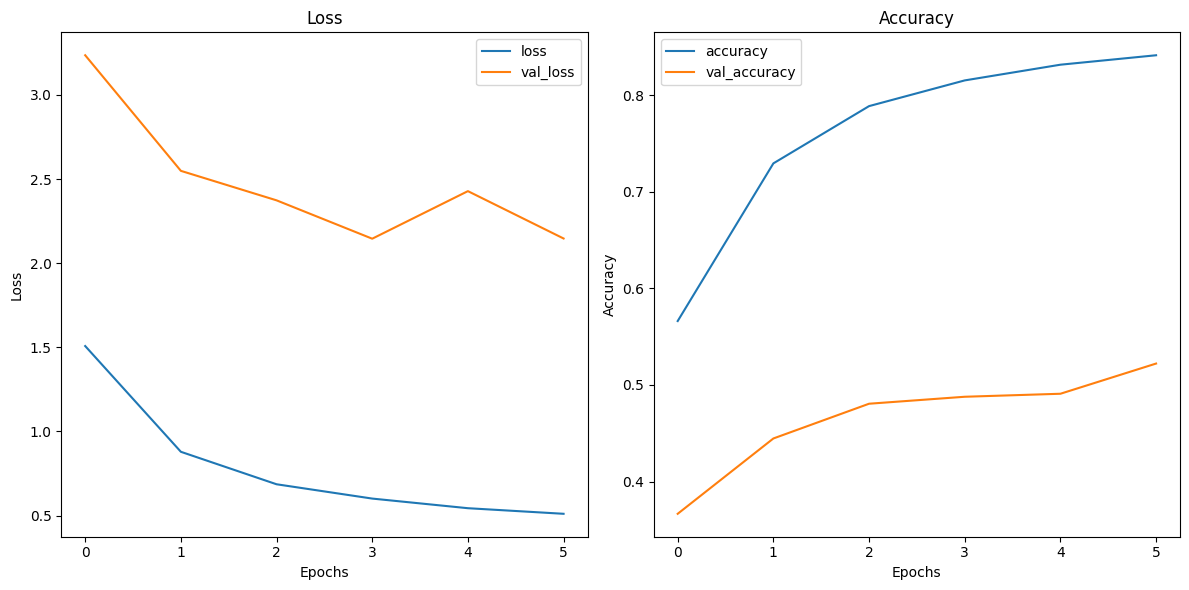

In [29]:
evaluation.plot_fit_history(history, ['loss', 'val_loss'],['accuracy', 'val_accuracy'])

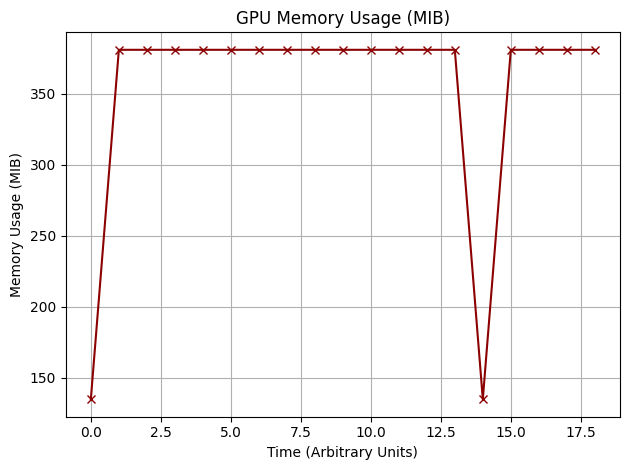

In [27]:
df_gpu_train = evaluation.get_gpu_usage(log_file_path)

# Evaluation
The model's performance on our test dataset is assessed using the top-1 error rate, which is the same metric employed by the dataset's creator.

In [30]:
test_df = preprocessing_tf.get_file_list(os.path.join(DATASET_SPLIT_PATH,"test"))
file_paths_test = tf.constant(test_df['filepath'].values)
labels_test = tf.constant(test_df['mapped_label'].values)
numeric_labels_test = label_lookup(labels_test)
test_dataset = tf.data.Dataset.from_tensor_slices((file_paths_test, numeric_labels_test))


In [31]:
test_spectrogram_ds = test_dataset.map(lambda fp, lbl: preprocessing_tf.preprocess_map_new(fp, lbl),
                               num_parallel_calls=tf.data.AUTOTUNE)

Padding shape: (16000,)
Signal shape: (16000,)
Spectrogram shape: (124, 129, 1)


In [32]:
batch_size = 32
test_spectrogram_ds = test_spectrogram_ds.batch(batch_size)

In [33]:
stop_event = threading.Event()
log_file_path = 'gpu_log_files/gpu_usage_baseline_model_test.txt'
interval = 10

In [34]:
thread = threading.Thread(target=evaluation.log_gpu_usage, args=(log_file_path, stop_event, interval), daemon=True)
thread.start()

In [35]:
start_time = time.time()
predictions = model.predict(test_spectrogram_ds)
end_time = time.time()
stop_event.set()
total_time_test = end_time - start_time
print(f"Total testing time: {total_time_test} seconds")

344/344 [==============================] - 18s 50ms/step
Total testing time: 17.928996801376343 seconds


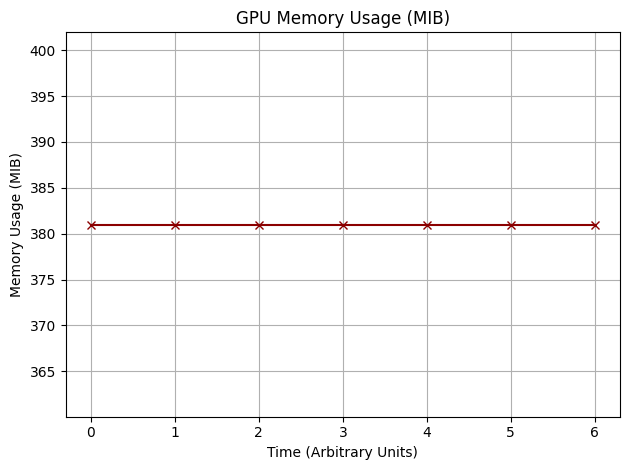

In [36]:
df_gpu_test = evaluation.get_gpu_usage(log_file_path)

In [37]:
true_labels = np.concatenate([y for x, y in test_spectrogram_ds], axis=0)
metrics_df = evaluation.get_error_metrics("Baseline Model", true_labels, predictions)
metrics_df.head()

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,Model Name,Precision,Recall,F1 Score,Accuracy,Cross-Entropy Loss
0,Baseline Model,0.736946,0.430621,0.402004,0.501772,2.306614


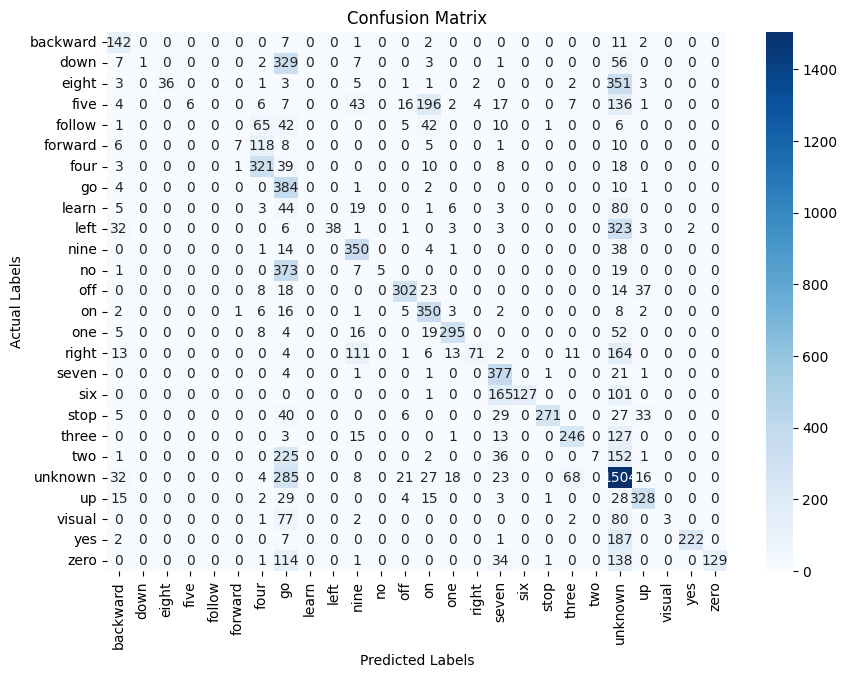

In [39]:
evaluation.plot_confusion_matrix(true_labels,predictions,label_lookup)

# Summary

In [41]:
mean_train = df_gpu_train['Memory Usage (MiB)'].mean()
mean_test = df_gpu_test['Memory Usage (MiB)'].mean()
max_train = df_gpu_train['Memory Usage (MiB)'].max()
max_test = df_gpu_test['Memory Usage (MiB)'].max()

In [43]:
print(f"Training time: {total_time_train:.3f} seconds")
print(f"Average GPU usage train: {mean_train:.3f} MiB")
print(f"Maximum GPU usage train: {max_train:.3f} MiB")

print(f"Testing time: {total_time_test:.3f} seconds")
print(f"Average GPU usage test: {mean_test:.3f} MiB")
print(f"Maximum GPU usage test: {max_test:.3f} MiB")

metrics_df.head()

Training time: 119.672 seconds
Average GPU usage train: 355.105 MiB
Maximum GPU usage train: 381.000 MiB
Testing time: 17.929 seconds
Average GPU usage test: 381.000 MiB
Maximum GPU usage test: 381.000 MiB


,Model Name,Precision,Recall,F1 Score,Accuracy,Cross-Entropy Loss
0,Baseline Model,0.736946,0.430621,0.402004,0.501772,2.306614
